In [1]:
!nvidia-smi

Wed Feb 10 03:44:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   53C    P0    70W / 300W |  22976MiB / 32478MiB |     51%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   50C    P0    72W / 300W |   6596MiB / 32478MiB |     39%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
# using gpu:/0
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

In [3]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [5]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset 분할

---

`Train` : `Test` = 0.75 : 0.25

- test

0-19 = 100명<br>
20-49 = 75명<br>
50- = 51명<br>

= 226 * 4 = 804개의 image

- train


0-19 = 299명

20-49 = 225명

50- = 154명

= 678 * 4 = 2712개의 image

In [6]:
import os
path_dir1 = '../sungjin/tooth3/train/'
path_dir2 = '../sungjin/tooth3/test/'

sub_directory = ['under20/','under50/','over50/']

TRAIN_NUM = 0
TEST_NUM = 0

for subdir in sub_directory:
    tmp_list = os.listdir(path_dir1+subdir)
    TRAIN_NUM += len(tmp_list)
    
for subdir in sub_directory:
    tmp2_list = os.listdir(path_dir2+subdir)
    TEST_NUM += len(tmp2_list)
    

In [7]:
# the number of training data = 2812
print(TRAIN_NUM)

2812


In [8]:
# the number of test data = 804
print(TEST_NUM)

804


In [9]:
import numpy as np

# preprocessing image

train_img = np.float32(np.zeros((TRAIN_NUM,151,112,3)))
train_label = np.uint8(np.zeros((TRAIN_NUM,)))

test_img = np.float32(np.zeros((TEST_NUM,151,112,3)))
test_label = np.uint8(np.zeros((TEST_NUM,)))

## Make Label

---

ImageDataGenerator는 directory별로 data augmentation

--> 두가지 네트워크를 비교했을 때 둘다 prediction에서 문제가 생김

따라서, 라벨링을 통해 다시한번 실험중

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

make_label = [0,1,2]

num = 0
idx = 0
for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir1+subdir):
        src_path = path_dir1 + subdir + file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        train_img[num, :, :, :] = x

        train_label[num] = give_label
        num = num + 1
    idx += 1

In [11]:
num = 0
idx = 0

for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir2+subdir):
        src_path = path_dir2 + subdir + file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        test_img[num, :, :, :] = x

        test_label[num] = give_label
        num = num + 1
    idx += 1

In [12]:
import keras

train_label = keras.utils.to_categorical(train_label,3)
test_label = keras.utils.to_categorical(test_label,3)

## Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator

datagen = ImageDataGenerator(
        #rescale=1./255, rescale시에 데이터가 모두 0에 근접
        #zoom_range = 0.2,
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images left and right
        vertical_flip=True)  # randomly flip images upside down

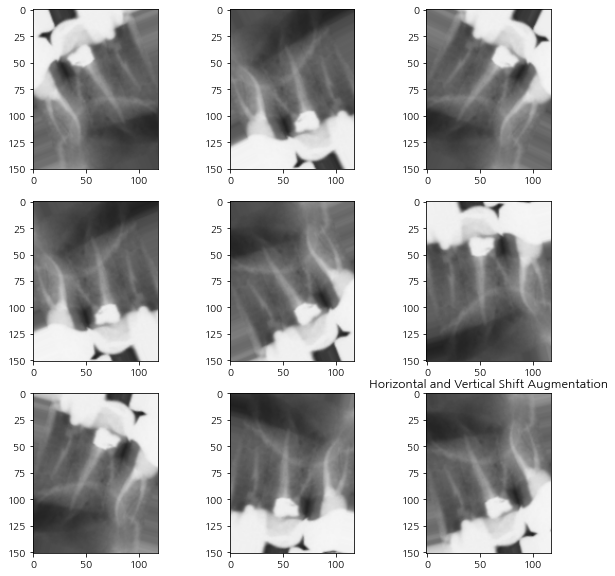

In [14]:
import matplotlib.pyplot as plt
# 첫 번째 차원을 추가하여 확장
img = load_img('../sungjin/tooth3/test/under50/20683982 기선미 16.png')
data = img_to_array(img)
samples = np.expand_dims(data, 0)
datagen = ImageDataGenerator(
        rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images left and right
        vertical_flip=True)
datagen.fit(train_img)
datagen.fit(test_img)


it = datagen.flow(samples, batch_size=32)

fig = plt.figure(figsize = (10,10))

# 9개 이미지 생성
for i in range(9):
    plt.subplot(3, 3, i+1)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

# show the figure
plt.title("Horizontal and Vertical Shift Augmentation")
plt.show()

## Transfer Learning

In [15]:
import tensorflow as tf
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,AveragePooling2D,Flatten,Dropout
from tensorflow import keras

base_model = keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=(151,112,3)
)

In [16]:
# base_model.trainable = False

### Classification 층만 삭제하고 FC

In [17]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 5, 4, 2048)        58370944  
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              41944064  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [18]:
model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [19]:
history = model.fit(datagen.flow(train_img,train_label,batch_size=32),
                    validation_data=datagen.flow(test_img,test_label,batch_size =32),
                    batch_size = 32,
                    epochs=20)
model.save("FC_add0210.h5")

Epoch 1/20
88/88 [==============================] - 29s 332ms/step - loss: 1.3895 - accuracy: 0.5156 - val_loss: 1.0396 - val_accuracy: 0.5808
Epoch 2/20
88/88 [==============================] - 21s 244ms/step - loss: 1.0338 - accuracy: 0.6454 - val_loss: 0.9699 - val_accuracy: 0.5945
Epoch 3/20
88/88 [==============================] - 28s 315ms/step - loss: 0.9135 - accuracy: 0.6831 - val_loss: 0.9109 - val_accuracy: 0.6443
Epoch 4/20
88/88 [==============================] - 28s 320ms/step - loss: 0.8557 - accuracy: 0.6938 - val_loss: 0.9768 - val_accuracy: 0.6443
Epoch 5/20
88/88 [==============================] - 20s 224ms/step - loss: 0.8035 - accuracy: 0.7212 - val_loss: 0.8827 - val_accuracy: 0.6891
Epoch 6/20
88/88 [==============================] - 26s 294ms/step - loss: 0.7422 - accuracy: 0.7361 - val_loss: 0.8416 - val_accuracy: 0.7002
Epoch 7/20
88/88 [==============================] - 28s 319ms/step - loss: 0.6857 - accuracy: 0.7543 - val_loss: 0.8522 - val_accuracy: 0.7065

In [20]:
history = model.fit(datagen.flow(train_img,train_label,batch_size=32),
                    validation_data=datagen.flow(test_img,test_label,batch_size =32),
                    batch_size = 32,
                    epochs=20)
model.save("FC_add0210-add20epoch.h5")

Epoch 1/20
88/88 [==============================] - 24s 268ms/step - loss: 0.3889 - accuracy: 0.8421 - val_loss: 0.7831 - val_accuracy: 0.7438
Epoch 2/20
88/88 [==============================] - 24s 268ms/step - loss: 0.3481 - accuracy: 0.8613 - val_loss: 0.7499 - val_accuracy: 0.7562
Epoch 3/20
88/88 [==============================] - 24s 268ms/step - loss: 0.3688 - accuracy: 0.8549 - val_loss: 0.8787 - val_accuracy: 0.7301
Epoch 4/20
88/88 [==============================] - 24s 269ms/step - loss: 0.3530 - accuracy: 0.8588 - val_loss: 0.9727 - val_accuracy: 0.7351
Epoch 5/20
88/88 [==============================] - 24s 271ms/step - loss: 0.3520 - accuracy: 0.8670 - val_loss: 0.8366 - val_accuracy: 0.7251
Epoch 6/20
88/88 [==============================] - 24s 270ms/step - loss: 0.3525 - accuracy: 0.8649 - val_loss: 0.8255 - val_accuracy: 0.7264
Epoch 7/20
88/88 [==============================] - 24s 268ms/step - loss: 0.3123 - accuracy: 0.8826 - val_loss: 0.8378 - val_accuracy: 0.7475

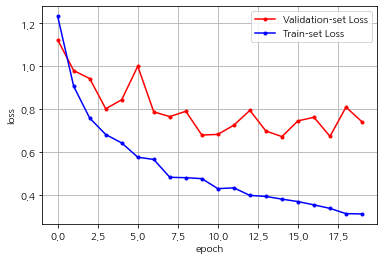

In [16]:
import numpy as np
import matplotlib.pyplot as plt

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

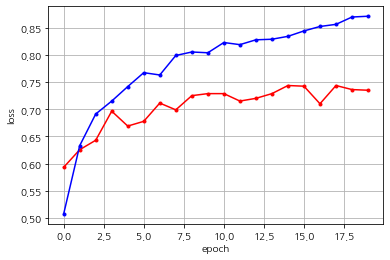

In [17]:
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_acc))

plt.plot(x_len, y_vacc, marker='.', c='red')
plt.plot(x_len, y_acc, marker='.', c='blue')

plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Predict 

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
path = '../sungjin/tooth3/test/'
path2 = '../sungjin/tooth3/test/'
subdir = ['under20/','under50/','over50/']
num = 0

for sub in subdir:
    num = 0
    print("--------------[predict]-------------")
    for file in os.listdir(path+sub):
        src_path = path + sub+file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = x.reshape(1,151,112,3)
        x = preprocess_input(x)
        
        preds = model.predict(x)
        
        print(np.argmax(preds), end= " ")
        num = num + 1
        
        if num == 30:
            break
    print("\n")
    


--------------[predict]-------------
0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

--------------[predict]-------------
2 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 

--------------[predict]-------------
2 2 2 2 1 2 1 2 2 1 1 2 1 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 



array([[0.05721931, 0.24046464, 0.70231605]], dtype=float32)

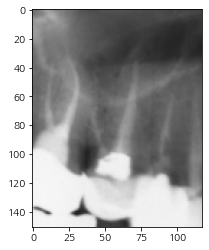

In [57]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(151, 112))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,151,112,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    
    return preds
make_predictions('../sungjin/tooth3/test/under50/20683982 기선미 16.png')

In [58]:
def predict_agegroup(image_path):
    preds = make_predictions(image_path)
    preds = np.argmax(preds)
    if preds == 0:
        print("나이는 0~19세 사이일 것입니다.")
    elif preds == 1:
        print("나이는 20~49세 사이일 것입니다.")
    else:
        print("나이는 50세 이상일 것입니다.")

나이는 50세 이상일 것입니다.


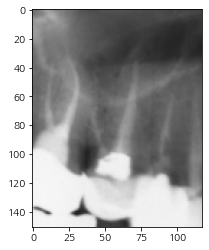

In [59]:
predict_agegroup('../sungjin/tooth3/test/under50/20683982 기선미 16.png')

나이는 20~49세 사이일 것입니다.


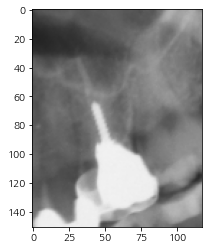

In [60]:
predict_agegroup('../sungjin/tooth3/test/under50/20683982 기선미 26.png')

나이는 20~49세 사이일 것입니다.


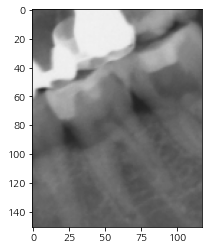

In [62]:
predict_agegroup('../sungjin/tooth3/test/under50/20683982 기선미 36.png')

나이는 20~49세 사이일 것입니다.


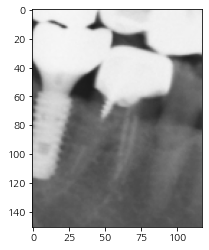

In [63]:
predict_agegroup('../sungjin/tooth3/test/under50/20683982 기선미 46.png')

나이는 50세 이상일 것입니다.


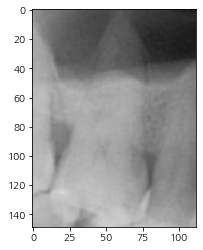

In [64]:
predict_agegroup('../sungjin/tooth3/test/over50/20683260 엄대용 16.png')

나이는 0~19세 사이일 것입니다.


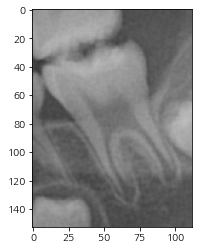

In [66]:
predict_agegroup('../sungjin/tooth3/test/under20/20681129 지민찬 36.png')

## ROC-AUC

In [22]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}